In [1]:
#import packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm 
import scipy.stats as stats
from stargazer.stargazer import Stargazer, LineLocation
import nltk
from nltk.corpus import stopwords
import lemmy

In [2]:
dataset = pd.read_csv("cleandata.csv",index_col="Unnamed: 0")


In [3]:
dateend = datetime(2021,2,4)
dstart = datetime(2020,2,26)
linde_date = datetime.strptime("2020-08-26", "%Y-%m-%d")

In [4]:
dataset['datetime'] = [datetime.strptime(d, "%Y-%m-%d") for d in dataset['datetime']]
dataset['date_clean'] = [datetime.strptime(str(d), "%Y-%m-%d") for d in dataset['date_clean']]
dataset = dataset[dataset['datetime'] > dstart]

In [5]:
dataset = dataset.reset_index(drop = True)

In [6]:
plt.rcParams.update({'font.size': 22})

In [7]:
mandater = {'Siumut' : 1, 
            'Liberal Alliance' : 3, 
            'Radikale venstre' : 14,
            'Socialdemokratiet' : 49, 
            'Venstre' : 40, 
            'SF' : 15, 
            'Konservative' : 12, 
            'DF': 16, 
            'Løsgænger' : 8,
            'Enhedslisten' : 13, 
            'Nye Borgerlige' : 4, 
            'Javnaðarflokkurin': 1, 
            'Alternativet' : 1,
            'Inuit Ataqatigiit' : 1}

# I remove all images without people in them

In [8]:
dataset = dataset[~dataset["share_women_no_none"].isnull()]


In [9]:
mean_women_set = dataset.groupby('date_clean').agg({'n_women': ['mean','sum']})
mean_women_set = mean_women_set['n_women'] 

In [10]:
dates = mean_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
mean_women_set['dates'] = dates
mean_women_set = mean_women_set.reset_index(drop = True)

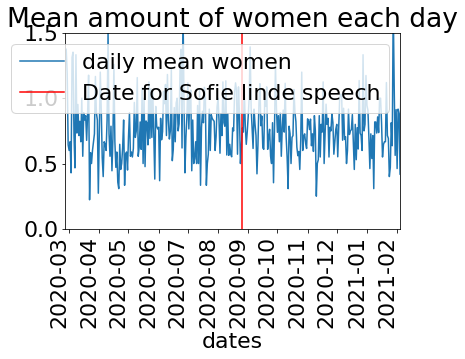

In [11]:
mean_women_set.plot(y = "mean",x = "dates", label = "daily mean women")
plt.xlim(dstart,dateend)
plt.ylim(0,1.5)
plt.xticks(rotation = 90)
plt.title("Mean amount of women each day")
plt.axvline(x = linde_date, color = 'r', label = 'Date for Sofie linde speech') 
plt.legend()

plt.show()

In [12]:
share_women_set = dataset.groupby('date_clean').agg({'share_women': ['mean','sum']})
share_women_set = share_women_set['share_women'] 

In [13]:
dates = share_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
share_women_set['dates'] = dates
share_women_set = share_women_set.reset_index(drop = True)

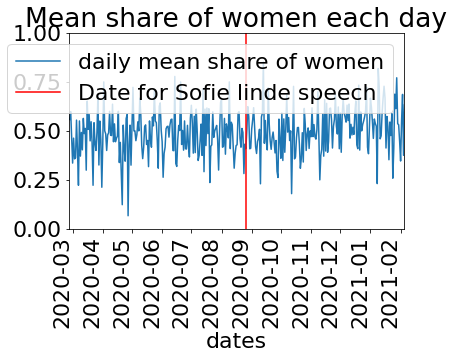

In [14]:
share_women_set.plot(y = "mean",x = "dates", label = "daily mean share of women")
plt.xlim(dstart,dateend)
plt.ylim(0,1)
plt.xticks(rotation = 90)
plt.title("Mean share of women each day")
plt.axvline(x = linde_date, color = 'r', label = 'Date for Sofie linde speech') 
plt.legend()

plt.show()

# Do discriptive stas on the smaller sample 

In [15]:
grouped_daily_women = dataset.groupby(["datetime","bloc"]).agg({"share_women": ['mean']})['share_women']


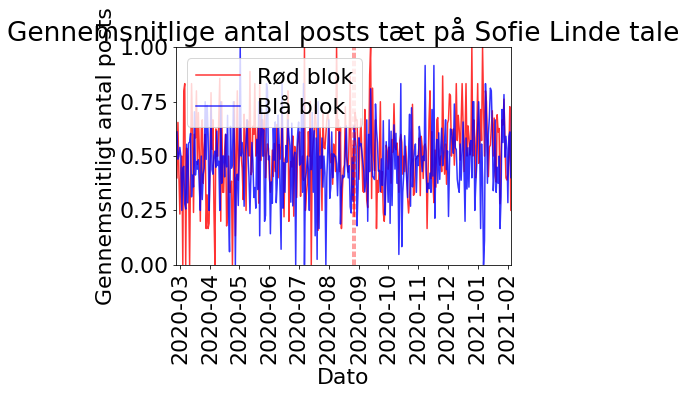

In [17]:
sns.lineplot(x='datetime',y='mean',hue = "bloc",data= grouped_daily_women,ci=None,palette= ["red","blue"],alpha = 0.8)
plt.ylabel("Gennemsnitligt antal posts")
plt.xlabel("Dato")
plt.xlim(dstart,dateend)
plt.axvline(x = linde_date, color = 'r', label = 'Dato for \nSofie linde tale', linestyle = "--", alpha = 0.5) 
plt.axvline(x = linde_date + timedelta(2), color = 'r', label = 'Dato for \nSofie linde tale på TV 2 Zulu', linestyle = "--", alpha = 0.5) 
plt.legend( loc='upper left', labels=['Rød blok', 'Blå blok'])

plt.xticks(rotation = 90)
#plt.legend(loc ="upper left")
plt.ylim(0,1)
plt.title("Gennemsnitlige antal posts tæt på Sofie Linde tale")
plt.show()

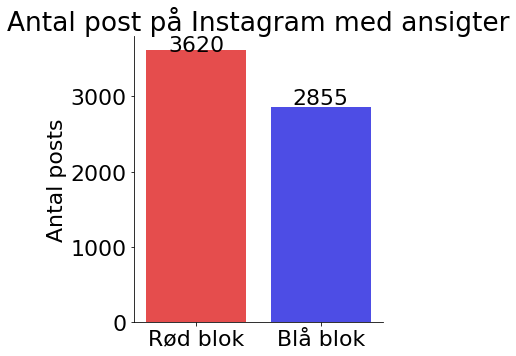

In [18]:
#plt.figure(figsize=(8, 8)) 
  
bars = sns.catplot(x='bloc', kind='count', data=dataset, palette= ["red","blue"],alpha = 0.8)
plt.annotate(sum(dataset['bloc']=="r"),(0,3600), ha='center')
plt.annotate(sum(dataset['bloc']=="b"),(1,2900), ha='center')


plt.xlabel("")
plt.ylabel("Antal posts")
plt.xticks([0,1],["Rød blok","Blå blok"])
plt.title("Antal post på Instagram med ansigter")

plt.show()

In [19]:
parties = dataset['party'].unique()
n_members = []
for party in parties:
        n_members.append(len(dataset[dataset['party'] == party]['user'].unique()))
        
        
party_users = pd.DataFrame(list(zip(parties, n_members,list(mandater.values()))), 
               columns =["party","users","mandates"]) 

party_users.sort_values(by = "mandates",ascending=False, inplace=True)
party_users = party_users.reset_index(drop = True)

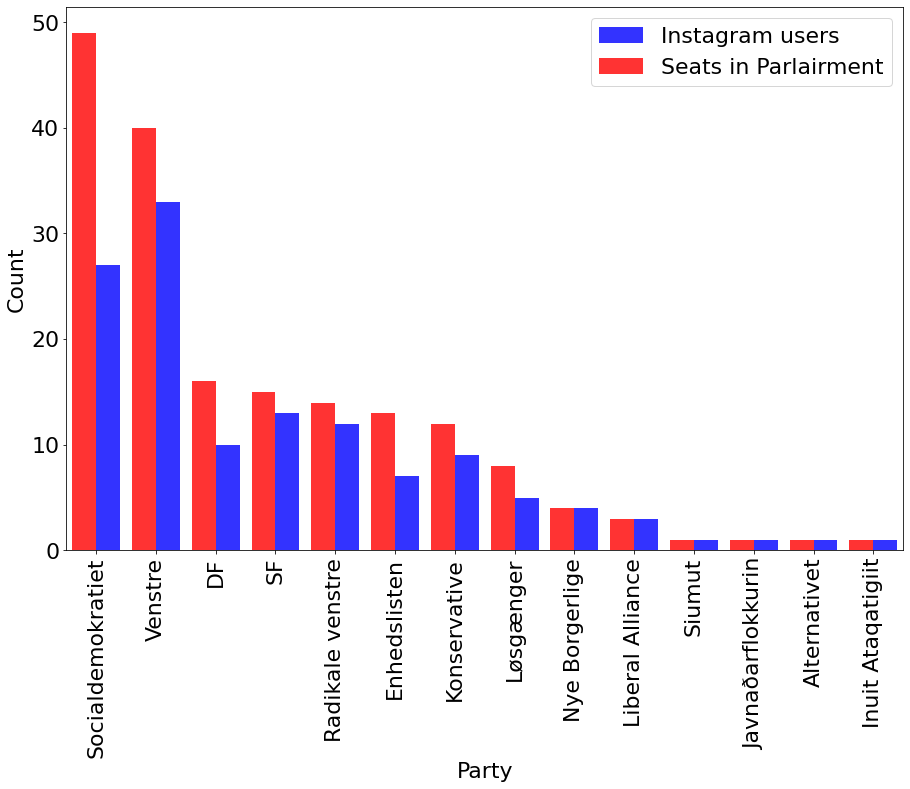

In [20]:
plt.figure(figsize=(15,10))
plt.bar(party_users.index + 0.2, party_users["users"],  0.40, label = "Instagram users", color = "b", alpha = 0.8)
plt.bar(party_users.index - 0.2, party_users["mandates"], 0.40, label = "Seats in Parlairment", color = "r", alpha = 0.8)
plt.legend()
plt.ylabel("Count")
plt.xlabel("Party")
plt.xlim(-0.5,13.5)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],party_users["party"], rotation = 90)
plt.show()

# Do simple ttest of mean 

In [21]:
def ttest_date(dataset, cutoff = datetime.strptime("2020-08-26", "%Y-%m-%d"),metric = "share_women"):
    before =dataset['datetime'] < cutoff
    after = dataset['datetime'] >= cutoff
    
    mean_before =  np.mean(dataset.loc[before,metric])
    mean_after =  np.mean(dataset.loc[after,metric])
    
    print("Mean", metric,"in posts in posts before:", mean_before)
    print("Mean", metric,"in posts in posts after:", mean_after)

    t, p = stats.ttest_ind(dataset.loc[before,metric],dataset.loc[after,metric] , equal_var=False)
    
    print("the t-value is:",t,"\n the p-value is:",p)
    print("the difference in mean is: ",round(mean_after-mean_before,3),"\n It is a change of", round(mean_after-mean_before,5) * 100,"percentage points more/less women")

Define dataset with only observations with faces and after start date

In [22]:
ttest_date(dataset, metric = "share_women_no_none")

Mean share_women_no_none in posts in posts before: 0.47656461324915067
Mean share_women_no_none in posts in posts after: 0.5061319115398629
the t-value is: -2.628012876679908 
 the p-value is: 0.008609528392325354
the difference in mean is:  0.03 
 It is a change of 2.957 percentage points more/less women


# Test if the samples are roughly equal in terms of y 

- https://towardsdatascience.com/how-to-compare-two-distributions-in-practice-8c676904a285 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html 
- https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test 
- https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets 



In [23]:
ks, p = stats.ks_2samp(dataset[dataset['treatment'] == 0]['share_women'],dataset[dataset['treatment'] == 1]['share_women'])

In [24]:
ks

0.03472795695819979

In [25]:
p

0.04044088767408438

# Simple OLS with share as y 

In [26]:
def do_regs(dataset, y = 'share_women', days = [14,7,3], cutoff = datetime.strptime("2020-8-26", "%Y-%m-%d")):
    '''this function perform some OLS regression with the dataset and y, looking at the amount of days from the cutoff'''
    tables = []
    #begin by making a full data reg
    dif = linde_date - cutoff
    dataset['temp_days_till_linde'] = dataset['days_till_linde'] + dif.days
    
    model1 = sm.ols(formula= y + " ~ treatment" , data = dataset).fit() 
    model2 = sm.ols(formula= y + " ~ temp_days_till_linde+treatment" , data = dataset).fit() 
    model3 = sm.ols(formula= y + " ~ temp_days_till_linde*treatment" , data = dataset).fit() 
    model4 = sm.ols(formula= y + " ~ temp_days_till_linde + treatment + np.power(temp_days_till_linde, 2) " , data = dataset).fit() 
    model5 = sm.ols(formula= y + " ~ temp_days_till_linde + treatment * np.power(temp_days_till_linde, 2) " , data = dataset).fit() 
    model6 = sm.ols(formula= y + " ~ temp_days_till_linde+treatment + bloc" , data = dataset).fit() 
    model7 = sm.ols(formula= y + " ~ treatment + bloc" , data = dataset).fit() 
    model8 = sm.ols(formula= y + " ~ treatment * bloc" , data = dataset).fit() 


    stargazer = Stargazer([model1,model2,model3,model4,model5,model6,model7,model8])
    stargazer.title('Full period')
    tables.append(stargazer)

    for day in days:
        model1 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit() 
        model2 = sm.ols(formula= y + " ~ temp_days_till_linde+treatment" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit() 
        model3 = sm.ols(formula= y + " ~ temp_days_till_linde*treatment" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit() 
        model4 = sm.ols(formula= y + " ~ temp_days_till_linde + treatment + np.power(temp_days_till_linde, 2)" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit() 
        model5 = sm.ols(formula= y + " ~ temp_days_till_linde + treatment * np.power(temp_days_till_linde, 2)" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit()
        model6 = sm.ols(formula= y + " ~ temp_days_till_linde+treatment + bloc" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit() 
        model7 = sm.ols(formula= y + " ~ treatment + bloc" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit() 
        model8 = sm.ols(formula= y + " ~ treatment * bloc" , data = dataset[abs(dataset['temp_days_till_linde']) <=day]).fit() 


        stargazer = Stargazer([model1,model2,model3,model4,model5,model6,model7,model8])
        stargazer.title(str(day) + "days")
        tables.append(stargazer)
    return tables

In [27]:
tabs = do_regs(dataset, "share_women", cutoff = linde_date)

In [28]:
tabs[0]

In [29]:
tabs[1]

In [30]:
tabs[2]

In [31]:
tabs[3]

### it seems like there could be some very local effect at around 3 days 

i try to plot the data 


In [32]:
share_women_set = dataset.groupby('date_clean').agg({'share_women': ['mean','sum']})
share_women_set = share_women_set['share_women'] 

In [33]:
dates = share_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
share_women_set['dates'] = dates
share_women_set = share_women_set.reset_index(drop = True)
dateend = datetime(2020,9,1)
dstart = datetime(2020,8,20)

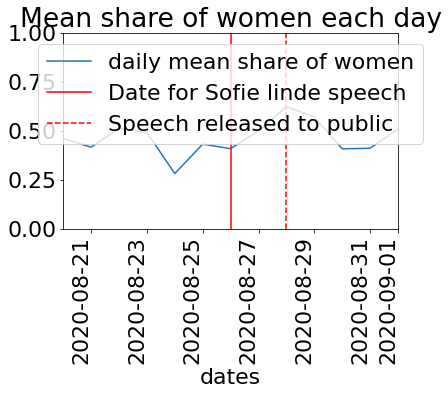

In [34]:
share_women_set.plot(y = "mean",x = "dates", label = "daily mean share of women")
plt.xlim(dstart,dateend)
plt.ylim(0,1)
plt.xticks(rotation = 90)
plt.title("Mean share of women each day")
plt.axvline(x = linde_date, color = 'r', label = 'Date for Sofie linde speech') 
plt.axvline(x = datetime.strptime("2020-8-28", "%Y-%m-%d") , color = 'r', label = 'Speech released to public', linestyle='--') 

plt.legend()

plt.show()

# Simple OLS with amount as y

In [35]:
tabs = do_regs(dataset, "n_women", cutoff = linde_date)

In [36]:
tabs[0]

In [37]:
tabs[1]

In [38]:
tabs[2]

In [39]:
tabs[3]

In [40]:
share_women_set = dataset.groupby('date_clean').agg({'n_women': ['mean','sum']})
share_women_set = share_women_set['n_women'] 

In [41]:
dates = share_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
share_women_set['dates'] = dates
share_women_set = share_women_set.reset_index(drop = True)
dateend = datetime(2020,9,1)
dstart = datetime(2020,8,20)

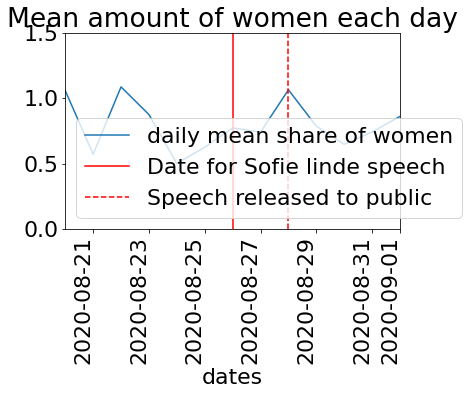

In [42]:
share_women_set.plot(y = "mean",x = "dates", label = "daily mean share of women")
plt.xlim(dstart,dateend)
plt.ylim(0,1.5)
plt.xticks(rotation = 90)
plt.title("Mean amount of women each day")
plt.axvline(x = linde_date, color = 'r', label = 'Date for Sofie linde speech') 
plt.axvline(x = datetime.strptime("2020-8-28", "%Y-%m-%d") , color = 'r', label = 'Speech released to public', linestyle='--') 

plt.legend()

plt.show()

# redo everyting with linde date as 28th

In [43]:
tabs = do_regs(dataset, "share_women", cutoff = datetime.strptime("2020-8-28", "%Y-%m-%d"))

In [44]:
tabs[0]

In [45]:
tabs[1]

In [46]:
tabs[2]

In [47]:
tabs[3]

## amount of women 

In [48]:
tabs = do_regs(dataset, "n_women", cutoff = datetime.strptime("2020-8-28", "%Y-%m-%d"))

In [49]:
tabs[0]

In [50]:
tabs[1]

In [51]:
tabs[2]

In [52]:
tabs[3]

# To do 
- Kontroller for blok og køn 
- lav en ny analyse hvor du ser på post med #metoo eller sofie linde i teksten vs dem uden - er der flere kvinder i dem? 
- - det er en indikator på at de bruge kvinder strategisk også 
- - det er det jeg er i gang med som nlp
- skriv analyse resultaterne ned 
- lav robusthedstjeks 
- se på raceklassifier? 
- se på familiebillleder? måske antal af personer - stiger det 


# Laver lidt nlp
- https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95
- https://github.com/sorenlind/lemmy

In [53]:
stop_words = set(stopwords.words('danish'))

In [54]:
lemmatizer = lemmy.load("da")

In [55]:
def text_clean(text):
    text = str(text).lower()
    text = nltk.tokenize.word_tokenize(text)
    text = [item for item in text if item not in stop_words]
    text = [lemmatizer.lemmatize("", item)[0] for item in text]
    text = [item for item in text if len(item) > 2]
    text = " ".join(text)
    
    return text

In [56]:
dataset['cleantext'] = dataset['text'].apply(text_clean)

In [57]:
dataset = dataset.reset_index(drop = True)

In [58]:
words = ["enblandtos", "sexis" ,"håndpålår", "ligestilling", "diskrimination", "metoo"]

In [59]:
dataset['topic_metoo'] = [1 if any(x in dataset.loc[i,'cleantext'] for x in words) else 0 for i in range(len(dataset))]

In [60]:
dataset[dataset['topic_metoo'] ==1 ]['share_women'].mean()

0.6373456790123457